In [1]:
import numpy as np
import copy

from numpy.core.numeric import moveaxis

In [64]:
KEY_TIE = 'tie'
KEY_ONGOING = 'ongoing'
KEY_WON_P1 = 'won_p1'
KEY_WON_P2 = 'won_p2'
KEY_P1 = 1
KEY_P2 = 2

n_games = 30000

alpha = 0.1
gamma = 1
init_epsilon = 0.05

win_reward = 1
lose_reward = -1
tie_reward = 0

In [3]:
def get_board_string(board):
    return str(copy.copy(board).reshape(9))

In [4]:
def get_q_values(_q_table, state, set_nan=True):

    next_board_string = get_board_string(state)

    if _q_table.get(next_board_string) is None:
        q_values = np.zeros([3,3]) 

        if set_nan:
            it = np.nditer(state, flags=['multi_index'])
            for x in it:
                if x != 0:
                    q_values[it.multi_index] = np.nan
    else:
        q_values = _q_table.get(next_board_string)

    return q_values

In [5]:
test_state_1 = np.array([[1,2,0],[0,0,2],[0,0,1]])
test_state_2 = np.array([[1,2,2],[1,1,2],[0,1,1]])

test_q_table = {'states': [test_state_1],
            'q_values' :[np.array([[np.nan,np.nan,1],[1,1,2],[0,2,2]])]}


get_q_values(test_q_table, test_state_2)

array([[nan, nan, nan],
       [nan, nan, nan],
       [ 0., nan, nan]])

In [20]:
def update_state(state, _q_table, epsilon, player_id):

    q_values = get_q_values(_q_table, state)
    
    r = np.random.rand()
    
    if np.all(np.isnan(q_values)) and not np.count_nonzero(state==0) == 0:
        print('ERROR: q values all zero but still a free spot')
        print(_q_table)

    if np.all(np.isnan(q_values)):
        return state

    if r < (1-epsilon):
        # find max of q table
        action_idxs = np.where(q_values == np.nanmax(q_values))
        ran_a_idx = np.random.randint(len(action_idxs[0]))
        action_idx = (action_idxs[0][ran_a_idx], action_idxs[1][ran_a_idx])
    else:
        non_nan_idxs = np.argwhere(~np.isnan(q_values))
        r_idx = np.random.randint(non_nan_idxs.shape[0])
        action_idx = non_nan_idxs[r_idx,:]

    new_state = copy.copy(state)
    new_state[action_idx[0], action_idx[1]] = player_id

    return new_state, action_idx

In [13]:
test_state_2 = np.array([[1,2,2],[1,1,2],[0,1,1]])

update_state(test_state_2, test_q_table, 1, 1)

array([[1, 2, 2],
       [1, 1, 2],
       [1, 1, 1]])

In [59]:
def update_q_table(q_table, action_idx, current_board, next_board, reward):

    board_string = get_board_string(current_board)
    q_table[board_string] = get_q_values(q_table, current_board)
    next_q_values = get_q_values(q_table, next_board)

    max_q_values = np.nanmax(next_q_values)
    if np.isnan(max_q_values):
        max_q_values = 0

    q_table[board_string][action_idx] += alpha*(reward + gamma * max_q_values - q_table[board_string][action_idx])

    return q_table

In [39]:
get_board_string(next_board)

'[1 2 2 1 0 0 1 0 0]'

In [60]:
test_q_table = {'[1 2 2 1 0 0 1 0 0]': [[np.nan,  np.nan, np.nan],
        [np.nan, 1,  1.],
        [np.nan, 1, 1]],
        '[1 0 2 1 0 0 0 0 0]': np.array([[np.nan, 0. , np.nan],
        [np.nan, 0.2, 0. ],
        [0. , 0. , 0. ]])}

current_board = np.array([[1,0,2],[1, 0, 0],[0,0,0]])
next_board = np.array([[1,2,2],[1, 0, 0],[1,0,0]])

update_q_table(test_q_table, (1,1), current_board, next_board, 1)


{'[1 2 2 1 0 0 1 0 0]': [[nan, nan, nan], [nan, 1, 1.0], [nan, 1, 1]],
 '[1 0 2 1 0 0 0 0 0]': array([[ nan, 0.  ,  nan],
        [ nan, 0.38, 0.  ],
        [0.  , 0.  , 0.  ]])}

In [17]:
def game_status(state):
    
    # check if someone has won
    possible_winning_comb = np.zeros((8, 3))
    possible_winning_comb[:3,:] = state
    possible_winning_comb[3:6,:] = state.T
    possible_winning_comb[6,:] = state.diagonal()
    possible_winning_comb[7,:] = np.fliplr(state).diagonal()
    
    for row in possible_winning_comb:
        if np.all(row == KEY_P1):
            return KEY_WON_P1
        elif np.all(row == KEY_P2):
            return KEY_WON_P2

    # check if tie
    if np.count_nonzero(state==0) == 0:
        return KEY_TIE

    return KEY_ONGOING

In [18]:
test_state_3 = np.array([[1,2,2],[1,2,2],[0,2,1]])
game_status(test_state_3)

'won_p2'

In [65]:
q_table1 = {}     
q_table2 = {}

results = []

epsilon = init_epsilon
# e_decay = epsilon/n_games
e_decay = 0

res_log_interval = 100
res_p1 = []
res_p2 = []
res_tie = []

rp1 = 0
rp2 = 0
rtie = 0

no_reward = 0

for i in range(n_games):

    if i % 100 == 0:
        res_p1.append(rp1)
        res_p2.append(rp2)
        res_tie.append(rtie)
        rp1 = 0
        rp2 = 0
        rtie = 0

    if i % 500 == 0:
        print('game ', i)

    if epsilon > 0:
        epsilon -= e_decay
    else:
        epsilon = 0

    # init board
    result = None
    board = np.zeros([3,3])
    last_board1 = np.zeros([3,3])
    last_board2 = np.zeros([3,3])

    _status = KEY_ONGOING

    # player 1 moves
    last_board1 = board
    board, action1 = update_state(board, q_table1, epsilon, KEY_P1)
    
    # player 2 moves
    last_board2 = board
    board, action2 = update_state(board, q_table2, epsilon, KEY_P2)

    # update q1
    q_table1 = update_q_table(q_table1, action1, last_board1, board, no_reward)

    while _status == KEY_ONGOING:
        # player 1 move 
        last_board1 = board
        board, action1 = update_state(board, q_table1, epsilon, KEY_P1)

        _status = game_status(board)
        if _status != KEY_ONGOING:
            result = _status
            break
        else:
            # update Q2
            q_table2 = update_q_table(q_table2, action2, last_board2, board, no_reward)

        # player 2 move 
        last_board2 = board
        board, action2 = update_state(board, q_table2, epsilon, KEY_P2)

        _status = game_status(board)
        if _status != KEY_ONGOING:
            result = _status
            break
        else:
            # update Q1
            q_table1 = update_q_table(q_table1, action1, last_board1, board, no_reward)

    # update q1 and q2 with corresponding reward
    if _status == KEY_WON_P1:
        q_table1 = update_q_table(q_table1, action1, last_board1, board, win_reward)
        q_table2 = update_q_table(q_table2, action2, last_board2, board, lose_reward)
        rp1 += 1
    elif _status == KEY_WON_P2:
        q_table1 = update_q_table(q_table1, action1, last_board1, board, win_reward)
        q_table2 = update_q_table(q_table2, action2, last_board2, board, lose_reward)
        rp2 += 1
    elif _status == KEY_TIE:       
        q_table1 = update_q_table(q_table1, action1, last_board1, board, tie_reward)
        q_table2 = update_q_table(q_table2, action2, last_board2, board, tie_reward)
        rtie += 1
    else:
        print('ERROR: unexpected result')

    results.append(_status)

print('done')

game  0


ipykernel_launcher:7: RuntimeWarning: All-NaN slice encountered


game  500
game  1000
game  1500
game  2000
game  2500
game  3000
game  3500
game  4000
game  4500
game  5000
game  5500
game  6000
game  6500
game  7000
game  7500
game  8000
game  8500
game  9000
game  9500
game  10000
game  10500
game  11000
game  11500
game  12000
game  12500
game  13000
game  13500
game  14000
game  14500
game  15000
game  15500
game  16000
game  16500
game  17000
game  17500
game  18000
game  18500
game  19000
game  19500
game  20000
game  20500
game  21000
game  21500
game  22000
game  22500
game  23000
game  23500
game  24000
game  24500
game  25000
game  25500
game  26000
game  26500
game  27000
game  27500
game  28000
game  28500
game  29000
game  29500
done


Text(0.5, 1.0, 'Winning statistics of tictactoe')

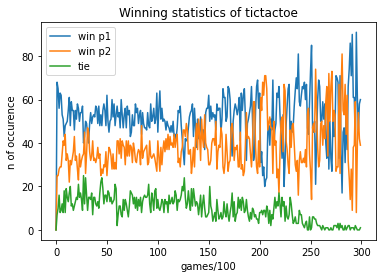

In [66]:
from matplotlib import pyplot as plt 

plt.plot(range(len(res_p1)), res_p1, label='win p1')
plt.plot(range(len(res_p2)), res_p2, label='win p2')
plt.plot(range(len(res_tie)), res_tie, label='tie')
plt.legend(loc="upper left")
plt.xlabel("games/100")
plt.ylabel("n of occurence")
plt.title("Winning statistics of tictactoe")

In [98]:
q_table1['states'][0]

array([[0., 0., 0.],
       [0., 0., 0.],
       [2., 1., 0.]])

In [130]:
q_table1['states'][15:20], q_table1['q_values'][15:20]

([array([[0., 2., 1.],
         [2., 2., 1.],
         [2., 1., 2.]]),
  array([[2., 1., 1.],
         [2., 2., 1.],
         [2., 1., 2.]]),
  array([[1., 0., 2.],
         [0., 0., 0.],
         [0., 0., 0.]]),
  array([[1., 0., 2.],
         [0., 0., 0.],
         [0., 0., 2.]]),
  array([[1., 2., 2.],
         [0., 0., 0.],
         [0., 0., 2.]])],
 [array([[ 0., nan, nan],
         [nan, nan, nan],
         [nan, nan, nan]]),
  array([[nan, nan, nan],
         [nan, nan, nan],
         [nan, nan, nan]]),
  array([[       nan, 0.0026663 ,        nan],
         [0.18716615, 0.08290443, 0.00263842],
         [0.18276668, 0.01329748, 0.17452111]]),
  array([[           nan, 3.43837811e-03,            nan],
         [1.46014275e-02, 0.00000000e+00, 2.54792059e-03],
         [1.51524377e-02, 3.22490000e-05,            nan]]),
  array([[       nan,        nan,        nan],
         [6.5341e-04, 0.0000e+00, 6.8590e-05],
         [8.5690e-04, 0.0000e+00,        nan]])])

In [ ]:
__states1 = np.concatenate(q_table1['states'], axis=1)
__q_values1 = np.concatenate(q_table1['q_values'], axis=1)
__final1 = np.concatenate((__states1, __q_values1), axis=0)
np.savetxt("player1.csv", __final1, delimiter=",")

__states2 = np.concatenate(q_table2['states'], axis=1)
__q_values2 = np.concatenate(q_table2['q_values'], axis=1)
__final2 = np.concatenate((__states2, __q_values2), axis=0)
np.savetxt("player2.csv", __final2, delimiter=",")

In [ ]:
%store results_count
results_count

In [ ]:
%store results
results

Stored 'results' (dict)


{'won_p1': 2344, 'won_p2': 2324, 'tie': 300}